### Setup - Install libraries and clone repo

In [ ]:
%%capture
!pip install torch
!pip install transformers
!pip install python-chess==0.31.2

In [ ]:
%%capture
!git clone https://github.com/shtoshni92/learning-chess-blindfolded.git

In [ ]:
%ls

learning-chess-blindfolded/  sample_data/


In [ ]:
import chess
import sys
import torch
import random
from transformers import GPT2LMHeadModel, AutoModel

sys.path.append("learning-chess-blindfolded/src")

from data_utils.chess_tokenizer import ChessTokenizer

### Initialize Model and Tokenizer

In [ ]:
vocab_path = "learning-chess-blindfolded/sample_data/lm_chess/vocab/uci/vocab.txt"
tokenizer = ChessTokenizer(vocab_path)

model = GPT2LMHeadModel.from_pretrained('shtoshni/gpt2-chess-uci')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/345M [00:00<?, ?B/s]

#### Display settings

In [ ]:
from IPython.display import HTML, display
from IPython.display import display, Image
from termcolor import colored

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

### Interactive play begins

Moves are to be specified in [UCI notation](https://en.wikipedia.org/wiki/Universal_Chess_Interface).
Typical command in UCI is a concatenation of starting square and ending square, for example "e2e4".


Enter your move in UCI (type x to quit): b2b3
LM plays: e7e5



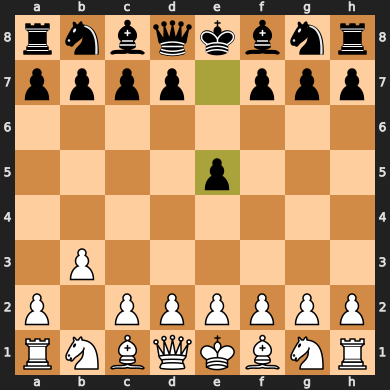

Enter your move in UCI (type x to quit): c1c2
c1c2 is not a legal move!
Legal move choices: c2c3, c1b2, c1a3, g2g4, h2h4, e2e4, e2e3, h2h3, b3b4, c2c4, a2a4, g2g3, f2f3, d2d3, f2f4, g1f3, d2d4, b1a3, g1h3, a2a3, b1c3
Enter your move in UCI (type x to quit): c1b2
LM plays: b8c6



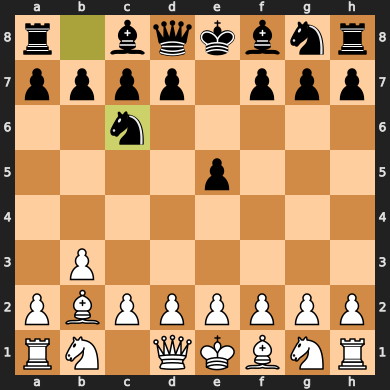

Enter your move in UCI (type x to quit): e2e3
LM plays: g8f6



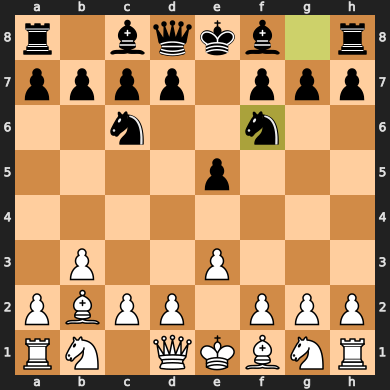

Enter your move in UCI (type x to quit): f1f5
f1f5 is not a legal move!
Legal move choices: c2c3, d1f3, d1c1, b2c1, f1c4, g2g4, h2h4, d1g4, f1d3, e1e2, b2d4, d1e2, h2h3, f1a6, b3b4, c2c4, g2g3, f1b5, a2a4, f2f3, d2d3, b2a3, f2f4, b2c3, g1f3, d1h5, d2d4, g1e2, b2e5, b1a3, g1h3, a2a3, e3e4, f1e2, b1c3
Enter your move in UCI (type x to quit): f1b5
LM plays: f8d6



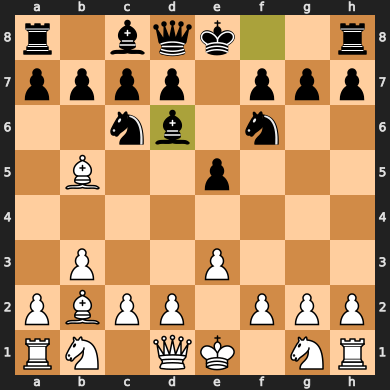

Enter your move in UCI (type x to quit): g1g3
g1g3 is not a legal move!
Legal move choices: c2c3, d1f3, b5e2, d1c1, b2c1, g2g4, h2h4, d1g4, b5a4, b5c4, b5d3, b5c6, e1e2, b2d4, d1e2, h2h3, b3b4, c2c4, a2a4, g2g3, f2f3, d2d3, b2a3, f2f4, b2c3, g1f3, d1h5, d2d4, b5f1, g1e2, b2e5, b1a3, e1f1, g1h3, a2a3, e3e4, b5a6, b1c3
Enter your move in UCI (type x to quit): g1f3
LM plays: e8g8



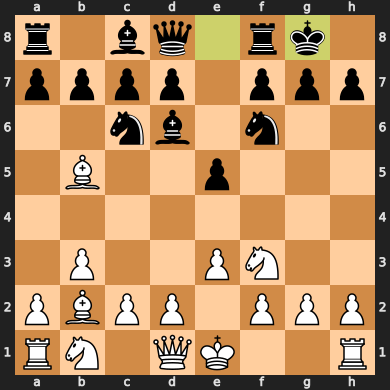

Enter your move in UCI (type x to quit): b5c6
LM plays: d7c6



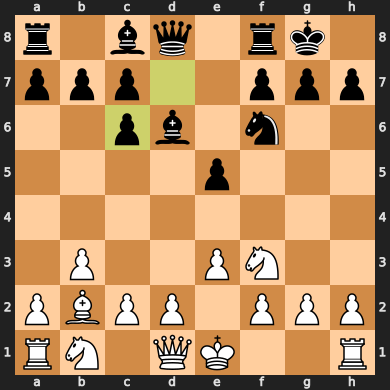

Enter your move in UCI (type x to quit): f3e5
LM plays: d8e7



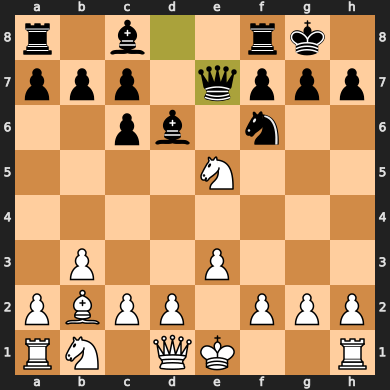

Enter your move in UCI (type x to quit): f2f4
LM plays: f6e4



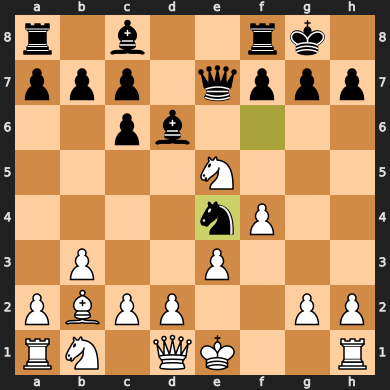

Enter your move in UCI (type x to quit): e1g1
LM plays: f7f6



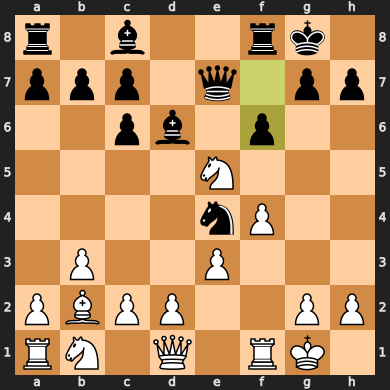

Enter your move in UCI (type x to quit): e5c4
LM plays: c8e6



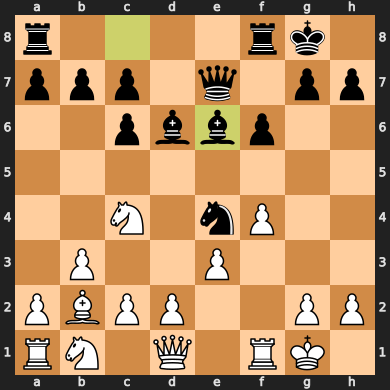

Enter your move in UCI (type x to quit): c4d6
LM plays: c7d6



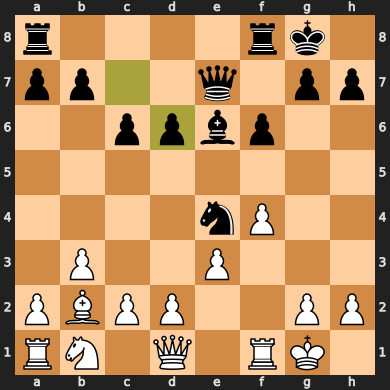

KeyboardInterrupt: Interrupted by user

In [ ]:
def get_legal_moves(board):
  legal_moves = set()
  for move in board.legal_moves:
    uci_move = board.uci(move)
    legal_moves.add(uci_move)

  return legal_moves


board = chess.Board()
game_prefix = [tokenizer.bos_token_id]
game_prefix_str = ""

while True:
  while True:
    move = input("Enter your move in UCI (type x to quit): ")
    if move == "x":
      break
    else:
      legal_moves = get_legal_moves(board)
      if move in legal_moves:
        break
      else:
        print(colored(f"{move} is not a legal move!", 'red'))
        print("Legal move choices:", ", ".join(list(legal_moves)))

  if move == "x":
    break
  # Make the move
  board.push_uci(move)

  game_prefix.extend(tokenizer.encode(move, add_special_tokens=False, get_move_end_positions=False))
  game_prefix_str += move + " "

  if board.is_game_over():
    print("Well played MATE")
    break
  elif board.is_stalemate():
    print("It's a STALE situation")
    break

  greedy_game_prefix = list(game_prefix)
  prefix_tens = torch.tensor([greedy_game_prefix])
  pred_move = ""
  for idx in range(3):
    logits = model(prefix_tens)[0]
    last_token_logit = logits[0, -1, :]

    token_idx = torch.argmax(last_token_logit).item()
    current_token = tokenizer.decode_token(token_idx)
    pred_move += current_token

    if idx == 0 and current_token == tokenizer.eos_token:
      break

    greedy_game_prefix += [token_idx]
    prefix_tens = torch.tensor([greedy_game_prefix])


  if pred_move == tokenizer.eos_token:
    print(colored("LM quits. Well played!", 'blue'))
    break

  if len(pred_move) == 6:
    pred_move = pred_move[:4]

  legal_moves = get_legal_moves(board)
  if pred_move in legal_moves:
    print(f"LM plays: {pred_move}")
  else:
    print(colored(f"Predicted move {pred_move} is illegal."), 'red')
    pred_move = random.sample(legal_moves, 1)[0]
    print("Randomly selected legal move:", pred_move)

  print()
  board.push_uci(pred_move)
  game_prefix.extend(tokenizer.encode(pred_move, add_special_tokens=False,
                                      get_move_end_positions=False))
  game_prefix_str += pred_move + " "

  display(board)
  # break


print("Thanks for playing! Here's the full game")
print(game_prefix_str)

